Ce notebook implémente un modèle hybride combinant un autoencoder et un modèle de régression pour l'analyse. 
Cette approche permet de :

- 1) Réduire la dimensionnalité des données tout en préservant l'information importante
- 2) Effectuer des prédictions sur des variables cibles
- 3) Reconstruire les séries originales si nécessaire

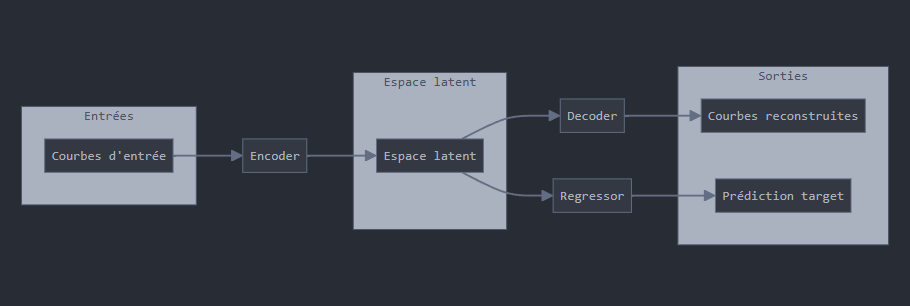

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.decoder(x)

class Regressor(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    
    def forward(self, x):
        return self.regressor(x)

class AutoencoderRegressor(nn.Module):
    def __init__(self, input_dim, latent_dim, target_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.regressor = Regressor(latent_dim, target_dim)
        
    def forward(self, x, mode='all'):
        latent = self.encoder(x)
        
        if mode == 'encode':
            return latent
        elif mode == 'regression':
            return self.regressor(latent)
        elif mode == 'decode':
            return self.decoder(latent)
        else:  # mode == 'all'
            reconstructed = self.decoder(latent)
            regression = self.regressor(latent)
            return reconstructed, regression, latent

def train_model(model, train_loader, n_epochs, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    reconstruction_criterion = nn.MSELoss()
    regression_criterion = nn.MSELoss()
    
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_curves, batch_targets in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, regression, _ = model(batch_curves)
            
            # Calculate losses
            reconstruction_loss = reconstruction_criterion(reconstructed, batch_curves)
            regression_loss = regression_criterion(regression, batch_targets)
            total_batch_loss = reconstruction_loss + regression_loss
            
            # Backward pass
            total_batch_loss.backward()
            optimizer.step()
            
            total_loss += total_batch_loss.item()
            
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Average Loss: {avg_loss:.4f}')


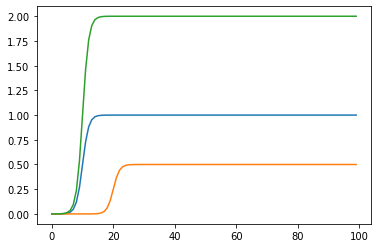

In [3]:
from matplotlib import pyplot as plt

#create a sigmoid function with delay and amplitude
def sigmoid(x, delay, amplitude):
    return amplitude / (1 + np.exp(-x + delay))

#example data
sigm_data = np.array([sigmoid(x, 10, 1) for x in range(100)])
sigm_data2 = np.array([sigmoid(x, 20, 0.5) for x in range(100)])
sigm_data3 = np.array([sigmoid(x, 10, 2) for x in range(100)])
sigm_data = np.expand_dims(sigm_data, axis=1)
sigm_data2 = np.expand_dims(sigm_data2, axis=1)
sigm_data3 = np.expand_dims(sigm_data3, axis=1)

plt.plot(sigm_data)
plt.plot(sigm_data2)
plt.plot(sigm_data3)


In [4]:
#create a dataset with random selection of delay and amplitude
class SigmoidDataset(Dataset):
    def __init__(self, n_samples):
        self.n_samples = n_samples
        self.data = []
        for _ in range(n_samples):
            delay = np.random.randint(0, 50)
            amplitude = np.random.uniform(0.1, 2)
            sigm_data = np.array([sigmoid(x, delay, amplitude) for x in range(100)])
            self.data.append(sigm_data)
        self.data = np.array(self.data)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.data[idx], np.array([idx % 2])

In [8]:
#create a dataset
dataset = SigmoidDataset(100)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Création et entraînement du modèle
model = AutoencoderRegressor(100, 10, 1)
train_model(model, dataloader, 100)



RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float